In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import time
from torch import nn
import torch.nn.functional as F
import torch
from torchvision import datasets, transforms
from torch import optim
from collections import OrderedDict
import helper

In [2]:
transform = transforms.Compose([transforms.ToTensor(), 
                               transforms.Normalize((0.5), (0.5))])

trainset = datasets.FashionMNIST('F_MNIST_data', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.FashionMNIST('F_MNIST_data', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

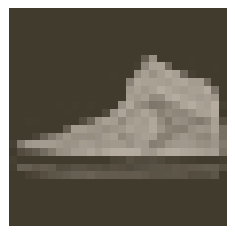

In [3]:
images, labels = next(iter(trainloader))
helper.imshow(images[1])


In [4]:
hidden_layer = [500, 200, 100, 50, 50]
hidden_layer = zip(hidden_layer[:-1], hidden_layer[1:])
for i in hidden_layer:
    print(i)

(500, 200)
(200, 100)
(100, 50)
(50, 50)


In [5]:
class Network(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, drop_p=0.5):
        super().__init__()
        self.network_layer = nn.ModuleList([nn.Linear(input_size, hidden_size[0])])
        layer_sizes = zip(hidden_size[:-1], hidden_size[1:])
        self.network_layer.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        self.output = nn.Linear(hidden_size[-1], output_size)
        self.dropout = nn.Dropout(p=drop_p)
    
    def forward(self, x):
        for linear_layer in self.network_layer:
            x = F.relu(linear_layer(x))
            x = self.dropout(x)
            
        x = self.output(x)
        
        return F.log_softmax(x, dim=1)

In [6]:
input_size = 784
hidden_size = [512, 256, 128]
output_size = 10
drop_p = 0.5
model = Network(input_size, hidden_size, output_size, drop_p)


In [7]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [8]:
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    for images, labels in testloader:
        images.resize_(images.shape[0], 784)
        output = model.forward(images)
        test_loss += criterion(output, labels).item()
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy

In [10]:
epochs = 1
print_every = 40
steps = 0
for e in range(epochs):
    runnings_loss = 0
    for images, labels in trainloader:
        steps += 1
        images.resize_(images.size()[0], input_size)
        optimizer.zero_grad()
        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        runnings_loss = loss.item()
        
        if steps % print_every == 0:
            model.eval()
            with torch.no_grad():
                test_loss, accuracy = validation(model, testloader, criterion)
            print(f'epochs:{e+1}/{epochs}',
                  'train loss:{:.4f}, '.format(runnings_loss/print_every), 
                 'test loss: {:.4f}, '.format(test_loss/len(testloader)), 
                 'test accuracy:{:.4f}'.format(accuracy/len(testloader)))
            runnings_loss = 0
            model.train()

epochs:1/1 train loss:0.0264,  test loss: 0.4831,  test accuracy:0.8238
epochs:1/1 train loss:0.0093,  test loss: 0.4750,  test accuracy:0.8237
epochs:1/1 train loss:0.0169,  test loss: 0.4709,  test accuracy:0.8220
epochs:1/1 train loss:0.0098,  test loss: 0.4792,  test accuracy:0.8207
epochs:1/1 train loss:0.0152,  test loss: 0.4767,  test accuracy:0.8252
epochs:1/1 train loss:0.0068,  test loss: 0.4666,  test accuracy:0.8354
epochs:1/1 train loss:0.0142,  test loss: 0.4689,  test accuracy:0.8267
epochs:1/1 train loss:0.0186,  test loss: 0.4674,  test accuracy:0.8323
epochs:1/1 train loss:0.0167,  test loss: 0.4629,  test accuracy:0.8318
epochs:1/1 train loss:0.0101,  test loss: 0.4630,  test accuracy:0.8328
epochs:1/1 train loss:0.0101,  test loss: 0.4632,  test accuracy:0.8282
epochs:1/1 train loss:0.0109,  test loss: 0.4750,  test accuracy:0.8292
epochs:1/1 train loss:0.0126,  test loss: 0.4675,  test accuracy:0.8333
epochs:1/1 train loss:0.0125,  test loss: 0.4642,  test accuracy

In [11]:
print(model)
print(model.state_dict().keys())

Network(
  (network_layer): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
odict_keys(['network_layer.0.weight', 'network_layer.0.bias', 'network_layer.1.weight', 'network_layer.1.bias', 'network_layer.2.weight', 'network_layer.2.bias', 'output.weight', 'output.bias'])


In [16]:
checkpoint = {'input_size':784, 
             'hidden_size':[each.out_features for each in model.network_layer], 
             'output_size':10, 
             'state_dict':model.state_dict()}

In [17]:
torch.save(checkpoint, "cp.pth")

In [21]:
def load_model(filepath):
    checkpoint = torch.load(filepath)
    model = Network(checkpoint['input_size'], 
                   checkpoint['hidden_size'], 
                   checkpoint['output_size'])
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

In [22]:
new_model = load_model("cp.pth")
print(new_model)

Network(
  (network_layer): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
